In [71]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

# Faithfulness-Utility Alignment Analysis

This notebook visualizes the relationship between empirical faithfulness and downstream utility (LDS).

**Output**: A 2×3 combined figure where:
- **Columns**: MNIST+LR, MNIST+MLP, CIFAR-2+ResNet9
- **Top row**: Test LDS vs λ for different projection dimensions m
- **Bottom row**: $\varepsilon_{95\%}$ vs λ

**UPDATED APPROACH**: 
- λ selection is done using the **TEST set** to directly answer: "Does the λ that maximizes utility fall in a faithful or unfaithful region?"
- This is NOT for model deployment but for scientific analysis of the faithfulness-utility alignment
- Stars (★) mark $\lambda^*(m) = \arg\max_\lambda \text{test\_LDS}$

**Error metric** (same as spectrum_bounds self-influence):
$$\varepsilon = \left|\frac{\tilde{\phi}_\lambda}{\phi_\lambda} - 1\right| = \frac{|\tilde{\phi}_\lambda - \phi_\lambda|}{\phi_\lambda}$$

We plot the 95th percentile of this error over test samples.

In [72]:
# Load all available faithfulness_utility results
# Note: MNIST uses "normal" projection, CIFAR-2 uses "sjlt"
fu_results_dir = "./results/faithfulness_utility"

# Define expected configurations with their projection types
configs = {
    'mnist_lr': 'sjlt',
    'mnist_mlp': 'sjlt',
    'cifar2_resnet9': 'sjlt',
}

# Load all results
all_results = {}
for name, proj_type in configs.items():
    # Try loading without _eps suffix first (newer format), then with suffix (older format)
    possible_paths = [
        f"{fu_results_dir}/{name}_{proj_type}.pt",
        f"{fu_results_dir}/{name}_{proj_type}_eps0.1.pt",
    ]

    loaded = False
    for path in possible_paths:
        if os.path.exists(path):
            results = torch.load(path, map_location="cpu", weights_only=False)
            all_results[name] = results
            meta = results.get('metadata', {})
            num_trials = results.get('num_trials', meta.get('num_trials', 1))
            print(f"Loaded {name} from {os.path.basename(path)}:")
            print(f"  dataset={meta.get('dataset', '?')}, model={meta.get('model', '?')}")
            print(f"  n_train={meta.get('n_train', '?')}, n_params={meta.get('n_params', '?'):,}")
            print(f"  m_values: {results.get('m_values', [])}")
            print(f"  num_trials: {num_trials}")
            print(f"  faithfulness_threshold: {results.get('faithfulness_threshold', 0.1)}")
            print()
            loaded = True
            break

    if not loaded:
        print(f"Warning: No results found for {name}")

print(f"Total loaded: {len(all_results)} / {len(configs)} configurations")

Loaded mnist_lr from mnist_lr_sjlt.pt:
  dataset=mnist, model=lr
  n_train=5000, n_params=7,850
  m_values: [32, 64, 128, 256, 512, 1024, 2048, 4096]
  num_trials: 5
  faithfulness_threshold: 0.01

Loaded mnist_mlp from mnist_mlp_sjlt.pt:
  dataset=mnist, model=mlp
  n_train=5000, n_params=109,386
  m_values: [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536]
  num_trials: 5
  faithfulness_threshold: 0.01

Loaded cifar2_resnet9 from cifar2_resnet9_sjlt.pt:
  dataset=cifar2, model=resnet9
  n_train=5000, n_params=4,825,154
  m_values: [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288]
  num_trials: 5
  faithfulness_threshold: 0.01

Total loaded: 3 / 3 configurations


In [73]:
# ============================================================================
# Recompute λ* based on TEST LDS (for faithfulness-utility alignment analysis)
# ============================================================================

def recompute_lambda_star_from_test_lds(results):
    """
    Recompute λ* for each m by selecting the λ that maximizes TEST LDS.

    This modifies the results dictionary in-place to update:
    - lambda_star: changed to argmax of test LDS
    - faithfulness_at_star: faithfulness metrics at the new λ*
    - test_lds_star: test LDS at the new λ*

    Args:
        results: Results dictionary loaded from .pt file
    """
    per_m = results['per_m_results']
    per_trial = results.get('per_trial_results', {})
    lambda_values = results['lambda_values']
    num_trials = len(per_trial) if per_trial else 1

    print("Recomputing λ* based on TEST LDS (instead of validation LDS):")
    print("-" * 80)

    for m in results['m_values']:
        if m not in per_m:
            continue

        data = per_m[m]

        # Get the old lambda_star (selected via validation)
        old_lambda_star = data['lambda_star']
        old_test_lds = data.get('test_lds_star', data.get('lds_star'))

        if num_trials > 1:
            # Average test LDS across all trials
            all_trial_test_lds = []
            for trial_idx in range(num_trials):
                trial_data = per_trial.get(trial_idx, {}).get(m, {})
                if 'all_test_lds' in trial_data:
                    all_trial_test_lds.append(trial_data['all_test_lds'])

            if all_trial_test_lds:
                mean_test_lds = np.mean(all_trial_test_lds, axis=0)
                # Find λ that maximizes average test LDS
                best_idx = np.argmax(mean_test_lds)
            else:
                # Fall back to stored data
                best_idx = np.argmax(data.get('all_test_lds', data.get('all_lds')))
        else:
            # Single trial: use stored test LDS
            test_lds_curve = data.get('all_test_lds', data.get('all_lds'))
            best_idx = np.argmax(test_lds_curve)

        # Get new lambda_star
        new_lambda_star = lambda_values[best_idx]
        new_test_lds = data['all_test_lds'][best_idx]
        new_faithfulness = data['all_faithfulness'][best_idx]

        # Update the stored values
        data['lambda_star'] = new_lambda_star
        data['test_lds_star'] = new_test_lds
        data['lds_star'] = new_test_lds  # Keep for compatibility
        data['faithfulness_at_star'] = new_faithfulness

        # Check if changed
        changed = "✓ CHANGED" if abs(new_lambda_star - old_lambda_star) / old_lambda_star > 0.01 else ""
        eps_95 = new_faithfulness.get('p95_error', float('nan'))

        print(f"m={m:6d}: λ_old={old_lambda_star:.2e} → λ_new={new_lambda_star:.2e}  "
              f"(test_LDS: {old_test_lds:.4f} → {new_test_lds:.4f}, ε₉₅={eps_95:.3f}) {changed}")

    print("-" * 80)
    print("Recomputation complete!\n")

# Apply recomputation to all loaded results
for name in all_results:
    print(f"\n{name.upper()}:")
    recompute_lambda_star_from_test_lds(all_results[name])


MNIST_LR:
Recomputing λ* based on TEST LDS (instead of validation LDS):
--------------------------------------------------------------------------------
m=    32: λ_old=4.71e-05 → λ_new=3.73e+00  (test_LDS: 0.1171 → 0.1339, ε₉₅=0.000) ✓ CHANGED
m=    64: λ_old=9.54e+00 → λ_new=2.33e+00  (test_LDS: 0.1615 → 0.1714, ε₉₅=0.001) ✓ CHANGED
m=   128: λ_old=9.10e-01 → λ_new=1.46e+00  (test_LDS: 0.2093 → 0.2157, ε₉₅=0.001) ✓ CHANGED
m=   256: λ_old=9.10e-01 → λ_new=9.10e-01  (test_LDS: 0.2565 → 0.2563, ε₉₅=0.001) 
m=   512: λ_old=9.10e-01 → λ_new=5.69e-01  (test_LDS: 0.3039 → 0.3059, ε₉₅=0.001) ✓ CHANGED
m=  1024: λ_old=3.56e-01 → λ_new=5.69e-01  (test_LDS: 0.3415 → 0.3467, ε₉₅=0.001) ✓ CHANGED
m=  2048: λ_old=5.69e-01 → λ_new=3.56e-01  (test_LDS: 0.3647 → 0.3701, ε₉₅=0.000) ✓ CHANGED
m=  4096: λ_old=3.56e-01 → λ_new=3.56e-01  (test_LDS: 0.3780 → 0.3792, ε₉₅=0.000) 
--------------------------------------------------------------------------------
Recomputation complete!


MNIST_MLP:
Recomputin

In [74]:
import math

def nearest_power_of_2(m):
    """Round m to nearest power of 2."""
    if m <= 0:
        return m
    log2_m = math.log2(m)
    lower = 2 ** int(log2_m)
    upper = 2 ** (int(log2_m) + 1)
    return lower if (m - lower) < (upper - m) else upper


def format_m_label(m):
    """Format m value as power of 2 in LaTeX notation: 2^{x}."""
    m_rounded = nearest_power_of_2(m)
    if m_rounded <= 0:
        return str(m_rounded)
    exp = int(round(math.log2(m_rounded)))
    return f'2^{{{exp}}}'


def get_averaged_lds_curves(results: dict, m: int) -> tuple:
    """
    Get LDS curves averaged across all trials for a given m value.

    Returns:
        (mean_test_lds, std_test_lds, lambda_star, lds_at_lambda_star, num_trials)
        where lds_at_lambda_star is the value from the averaged curve at lambda_star,
        ensuring the star marker lies exactly on the plotted line.
    """
    per_trial = results.get('per_trial_results', {})
    per_m = results['per_m_results']
    lambda_values = results['lambda_values']
    num_trials = len(per_trial)

    if num_trials <= 1 or m not in per_m:
        # Single trial or no per-trial data: use stored values directly
        data = per_m[m]
        if 'all_test_lds' in data:
            lds_values = data['all_test_lds']
        else:
            lds_values = data['all_lds']

        lambda_star = data['lambda_star']
        # Get LDS value at lambda_star from the curve itself
        lambda_star_idx = lambda_values.index(lambda_star)
        lds_at_lambda_star = lds_values[lambda_star_idx]

        return lds_values, None, lambda_star, lds_at_lambda_star, num_trials

    # Multiple trials: average across all trials
    all_trial_lds = []
    for trial_idx in range(num_trials):
        trial_data = per_trial.get(trial_idx, {}).get(m, {})
        if 'all_test_lds' in trial_data:
            all_trial_lds.append(trial_data['all_test_lds'])

    if not all_trial_lds:
        # Fall back to stored per_m data
        data = per_m[m]
        lds_values = data.get('all_test_lds', data.get('all_lds', []))
        lambda_star = data['lambda_star']
        lambda_star_idx = lambda_values.index(lambda_star)
        lds_at_lambda_star = lds_values[lambda_star_idx]
        return lds_values, None, lambda_star, lds_at_lambda_star, num_trials

    # Average and std across trials
    all_trial_lds_np = np.array(all_trial_lds)
    mean_test_lds = np.mean(all_trial_lds_np, axis=0).tolist()
    std_test_lds = np.std(all_trial_lds_np, axis=0, ddof=1).tolist() if num_trials > 1 else None
    lambda_star = per_m[m]['lambda_star']

    # Get LDS value at lambda_star from the AVERAGED curve
    lambda_star_idx = lambda_values.index(lambda_star)
    lds_at_lambda_star = mean_test_lds[lambda_star_idx]

    return mean_test_lds, std_test_lds, lambda_star, lds_at_lambda_star, num_trials


def plot_faithfulness_utility_combined(all_results: dict, save_path=None, figsize=(18, 10),
                                       wspace=0.2, hspace=0.1, ci_alpha=0.2, lambda_ranges="default"):
    """
    Plot 2×3 combined figure: Test LDS vs λ (top row) and ε_95 vs λ (bottom row).

    Each column corresponds to one dataset-model combo.
    Each subplot shows all available m values.

    Confidence intervals are automatically shown when multiple trials are available.
    Style matched to spectrum_bounds.ipynb and hyperparam_selection.ipynb.

    **Important**:
    - Top row shows TEST LDS averaged across trials
    - Shaded regions show 95% confidence intervals
    - λ* is selected to MAXIMIZE TEST LDS (for faithfulness-utility alignment analysis)
    - Star markers show the test LDS at λ* = argmax(test LDS)
    - This directly answers: "Does optimal utility coincide with good faithfulness?"

    Error metric (same as spectrum_bounds self-influence):
        ε = |φ̃_λ/φ_λ - 1| = |φ̃_λ - φ_λ| / φ_λ
    We plot the 95th percentile of this error over test samples.

    Args:
        all_results: Dictionary of results for each dataset-model combo
        save_path: Path to save the figure
        figsize: Figure size (width, height)
        wspace: Width space between subplots
        hspace: Height space between subplots
        ci_alpha: Alpha for confidence interval shading (default: 0.2)
        lambda_ranges: Dict mapping config name (e.g., "mnist_lr") to (min_lambda, max_lambda) tuple,
            or "default" to use sensible defaults, or None to show all lambda values (e.g., "mnist_lr") to (min_lambda, max_lambda) tuple
    """
    from matplotlib.lines import Line2D

    # Define default lambda ranges for each dataset-model combo
    if lambda_ranges == "default":
        lambda_ranges = {
            "mnist_lr": (1e-5, 1e2),      # LR: focus on smaller regularization
            "mnist_mlp": (1e-6, 1e2),     # MLP: moderate range
            "cifar2_resnet9": (1e-8, 1e-1), # ResNet: larger models need more regularization
        }
    elif lambda_ranges is None:
        lambda_ranges = {}  # Empty dict means no filtering
    # Fixed order for plotting (columns)
    plot_order = ['mnist_lr', 'mnist_mlp', 'cifar2_resnet9']
    display_names = {
        'mnist_lr': 'MNIST + LR',
        'mnist_mlp': 'MNIST + MLP',
        'cifar2_resnet9': 'CIFAR-2 + ResNet9'
    }

    # Filter to only available results
    available = [name for name in plot_order if name in all_results]
    n_cols = len(available)

    if n_cols == 0:
        print("No results available to plot.")
        return None

    fig, axes = plt.subplots(2, n_cols, figsize=figsize)

    # Handle case of single column
    if n_cols == 1:
        axes = axes.reshape(2, 1)

    # Collect all m values across datasets for consistent coloring
    all_m_values = set()
    for name in available:
        all_m_values.update(all_results[name]['m_values'])
    all_m_values = sorted(all_m_values)

    # Create color map for m values
    m_colors = {m: plt.cm.plasma(i / max(1, len(all_m_values) - 1))
                for i, m in enumerate(all_m_values)}

    for col_idx, name in enumerate(available):
        results = all_results[name]
        m_values = results['m_values']
        lambda_values = np.array(results['lambda_values'])

        # Filter lambda values if range is specified for this config
        lambda_indices = None  # Track which lambda indices to keep
        if lambda_ranges and name in lambda_ranges:
            lambda_min, lambda_max = lambda_ranges[name]
            # Create boolean mask for lambda values in range
            lambda_mask = [(lambda_min <= l <= lambda_max) for l in lambda_values]
            lambda_indices = [idx for idx, keep in enumerate(lambda_mask) if keep]
            lambda_values = lambda_values[lambda_mask]
        per_m = results['per_m_results']
        threshold = results.get('faithfulness_threshold', 0.1)
        num_trials = results.get('num_trials', 1)

        # Compute t-value for confidence intervals
        t_value = 1.96 if num_trials > 30 else {2: 12.71, 3: 4.30, 4: 3.18, 5: 2.78,
                                                  6: 2.57, 7: 2.45, 8: 2.36, 9: 2.31,
                                                  10: 2.26}.get(num_trials, 2.0)

        # =====================================================================
        # Top row: TEST LDS vs λ (unbiased evaluation, averaged across trials)
        # =====================================================================
        ax_top = axes[0, col_idx]

        for m in m_values:
            if m not in per_m:
                continue
            color = m_colors[m]

            # Get averaged LDS curve, std, and star position
            lds_values, lds_std, lambda_star, lds_star, n_trials_m = get_averaged_lds_curves(results, m)

            # Filter data arrays if lambda range was specified
            if lambda_indices is not None:
                lds_values = [lds_values[i] for i in lambda_indices]
                if lds_std is not None:
                    lds_std = [lds_std[i] for i in lambda_indices]

            # Plot curve (TEST LDS, averaged across trials)
            ax_top.semilogx(lambda_values, lds_values, 'o-', color=color,
                           markersize=5, linewidth=1.5, alpha=0.8)

            # Add confidence interval when multiple trials available
            if lds_std is not None and n_trials_m > 1:
                lds_std_np = np.array(lds_std)
                lds_se = lds_std_np / np.sqrt(n_trials_m)
                lds_ci = t_value * lds_se
                lds_lower = np.array(lds_values) - lds_ci
                lds_upper = np.array(lds_values) + lds_ci
                ax_top.fill_between(lambda_values, lds_lower, lds_upper, color=color, alpha=ci_alpha)

            # Mark λ*(m) with a star (on the averaged curve)
            # Only plot star if lambda_star is in the filtered range
            if lambda_indices is None or lambda_star in lambda_values:
                ax_top.scatter([lambda_star], [lds_star], s=300, c=[color],
                          marker='*', zorder=5, edgecolors='black', linewidths=0.5)

        ax_top.set_title(display_names[name], fontsize=24)
        ax_top.tick_params(axis='both', which='major', labelsize=20)
        # ax_top.set_xlabel('$\lambda$', fontsize=28)
        ax_top.grid(True, alpha=0.3)

        # Format y-axis to show 2 decimal places
        from matplotlib.ticker import FormatStrFormatter
        ax_top.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

        # Only show y-label on leftmost column
        if col_idx == 0:
            ax_top.set_ylabel('LDS', fontsize=28)

        # =====================================================================
        # Bottom row: ε_95 vs λ (same metric as spectrum_bounds self-influence)
        # =====================================================================
        ax_bot = axes[1, col_idx]

        all_eps = []
        for m in m_values:
            if m not in per_m:
                continue
            color = m_colors[m]
            data = per_m[m]

            # Get mean faithfulness metrics (already averaged)
            all_faith = data.get('all_faithfulness', [])

            if all_faith:
                eps_values = [f.get('p95_error', float('nan')) for f in all_faith]
                # Filter eps_values if lambda range was specified
                if lambda_indices is not None:
                    eps_values = [eps_values[idx] for idx in lambda_indices]

                all_eps.extend([e for e in eps_values if np.isfinite(e) and e > 0])

                # Plot curve (log-log)
                ax_bot.loglog(lambda_values, eps_values, 'o-', color=color,
                             markersize=5, linewidth=1.5, alpha=0.8)

                # Add confidence interval for error when multiple trials available
                per_trial = results.get('per_trial_results', {})
                if len(per_trial) > 1:
                    # Collect eps values across trials for this m
                    all_trial_eps = []
                    for trial_idx in range(len(per_trial)):
                        trial_data = per_trial.get(trial_idx, {}).get(m, {})
                        trial_faith = trial_data.get('all_faithfulness', [])
                        if trial_faith:
                            trial_eps = [f.get('p95_error', float('nan')) for f in trial_faith]
                            all_trial_eps.append(trial_eps)

                    if len(all_trial_eps) > 1:
                        # Compute mean and std across trials

                        all_trial_eps_np = np.array(all_trial_eps)
                        # Filter trial data if lambda range was specified
                        if lambda_indices is not None:
                            all_trial_eps_np = all_trial_eps_np[:, lambda_indices]
                        eps_std = np.std(all_trial_eps_np, axis=0, ddof=1)
                        eps_se = eps_std / np.sqrt(len(all_trial_eps))
                        eps_ci = t_value * eps_se

                        eps_lower = np.maximum(np.array(eps_values) - eps_ci, np.array(eps_values) * 0.01)
                        eps_upper = np.array(eps_values) + eps_ci

                        # Only plot CI for valid (positive) values
                        valid_mask = np.isfinite(eps_values) & (np.array(eps_values) > 0)
                        if valid_mask.any():
                            ax_bot.fill_between(lambda_values, eps_lower, eps_upper,
                                              color=color, alpha=ci_alpha, where=valid_mask)

                # Mark λ*(m) with a star
                lambda_star = data['lambda_star']
                faith_at_star = data.get('faithfulness_at_star', {})
                eps_at_star = faith_at_star.get('p95_error', float('nan'))
                if np.isfinite(eps_at_star) and eps_at_star > 0:
                    if lambda_indices is None or lambda_star in lambda_values:
                        ax_bot.scatter([lambda_star], [eps_at_star], s=300, c=[color],
                                  marker='*', zorder=5, edgecolors='black', linewidths=0.5)

        # Set y-limits based on data
        if all_eps:
            ax_bot.set_ylim(min(all_eps) * 0.5, max(all_eps) * 2.0)

        ax_bot.tick_params(axis='both', which='major', labelsize=20)
        ax_bot.set_xlabel('$\lambda$', fontsize=28)
        ax_bot.grid(True, alpha=0.3)


        # Format y-axis to use scientific notation (10^{-x})
        from matplotlib.ticker import LogFormatterSciNotation
        ax_bot.yaxis.set_major_formatter(LogFormatterSciNotation())

        # Only show y-label on leftmost column
        if col_idx == 0:
            ax_bot.set_ylabel(r'$_{95\%}\, \varepsilon_{\lambda}$', fontsize=28)

    plt.tight_layout()
    plt.subplots_adjust(wspace=wspace, hspace=hspace)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Saved figure to {save_path}")

    plt.show()
    return fig


def create_m_colorbar(all_results: dict, save_path=None, figsize=(8, 1.2), fontsize=28):
    """
    Create a standalone horizontal colorbar for m values.

    This function exactly matches the structure of create_lambda_colorbar from spectrum_bounds.ipynb,
    but creates a colorbar for m values using the plasma colormap.

    Args:
        all_results: Dictionary of results to extract m values from
        save_path: Path to save the colorbar figure
        figsize: Figure size (width, height)
        fontsize: Font size for colorbar label and ticks

    Returns:
        fig: The colorbar figure
    """
    from matplotlib.colors import LogNorm
    from matplotlib.cm import ScalarMappable

    # Collect all m values across datasets
    all_m_values = set()
    for results in all_results.values():
        all_m_values.update(results['m_values'])
    all_m_values = sorted(all_m_values)

    if not all_m_values:
        print("No m values found")
        return None

    m_min = min(all_m_values)
    m_max = max(all_m_values)

    fig, ax = plt.subplots(figsize=figsize)

    # Create colorbar using plasma colormap with log normalization
    cmap = plt.cm.plasma
    norm = LogNorm(vmin=m_min, vmax=m_max)
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    cbar = plt.colorbar(sm, cax=ax, orientation='horizontal')
    cbar.ax.set_ylabel('$m$', fontsize=fontsize, weight='bold', rotation=0, labelpad=15, y=0.05)
    cbar.ax.tick_params(labelsize=fontsize-2)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Saved m colorbar to {save_path}")

    plt.show()
    return fig


def create_lambda_star_legend(save_path=None, figsize=(6, 1.2), fontsize=28):
    """
    Create a standalone legend for the λ* star marker.

    Args:
        save_path: Path to save the legend figure
        figsize: Figure size (width, height)
        fontsize: Font size for legend text

    Returns:
        fig: The legend figure
    """
    from matplotlib.lines import Line2D

    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('off')

    # Create star handle with larger marker size
    star_handle = Line2D([0], [0], marker='*', color='gray', linestyle='None',
                        markersize=30, markeredgecolor='black', markeredgewidth=0.5)

    # Add legend with no frame
    legend = ax.legend([star_handle], ['$\\lambda^* = \\arg\\max_{\\lambda}\ \\text{LDS}_\\lambda$'],
                      loc='center', fontsize=fontsize, frameon=False)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Saved lambda star legend to {save_path}")

    plt.show()
    return fig


def print_fu_summary_table(all_results):
    """Print a summary table with empirical faithfulness metrics.

    Shows TEST LDS where λ* = argmax(test LDS).
    """
    print(f"{'Dataset-Model':<20} | {'m_max':>8} | {'λ*(m)':>10} | {'Test LDS*':>10} | {'ε_95':>8} | {'#trials':>7}")
    print("-" * 85)

    for name, results in all_results.items():
        m_values = results['m_values']
        per_m = results['per_m_results']
        m_max = max(m_values)

        data = per_m[m_max]
        faith = data.get('faithfulness_at_star', {})
        eps = faith.get('p95_error', float('nan'))

        # Use test_lds_star (new format) or lds_star (old format)
        if 'test_lds_star' in data:
            lds_star = data['test_lds_star']
            lds_std = data.get('test_lds_star_std', 0.0)
        else:
            lds_star = data['lds_star']
            lds_std = data.get('lds_star_std', 0.0)

        n_trials = data.get('n_trials', results.get('num_trials', 1))

        # Show m_max rounded to nearest power of 2
        m_display = nearest_power_of_2(m_max)

        # Format LDS with std if available
        if lds_std > 0:
            lds_str = f"{lds_star:.4f}±{lds_std:.3f}"
        else:
            lds_str = f"{lds_star:.4f}"

        print(f"{name:<20} | {m_display:>8} | {data['lambda_star']:>10.2e} | "
              f"{lds_str:>10} | {eps:>8.3f} | {n_trials:>7}")

Summary Table (λ* selected via argmax test LDS):
Dataset-Model        |    m_max |      λ*(m) |  Test LDS* |     ε_95 | #trials
-------------------------------------------------------------------------------------
mnist_lr             |     4096 |   3.56e-01 | 0.3792±0.002 |    0.000 |       5
mnist_mlp            |    65536 |   2.12e-02 | 0.1867±0.001 |    0.001 |       5
cifar2_resnet9       |   524288 |   4.50e-06 | 0.1918±0.005 |    0.000 |       5

Plotting Combined 2×3 Figure
(Top row: Test LDS, Bottom row: ε_95)


Saved figure to ./figures/faithfulness_utility/faithfulness_utility_combined.pdf


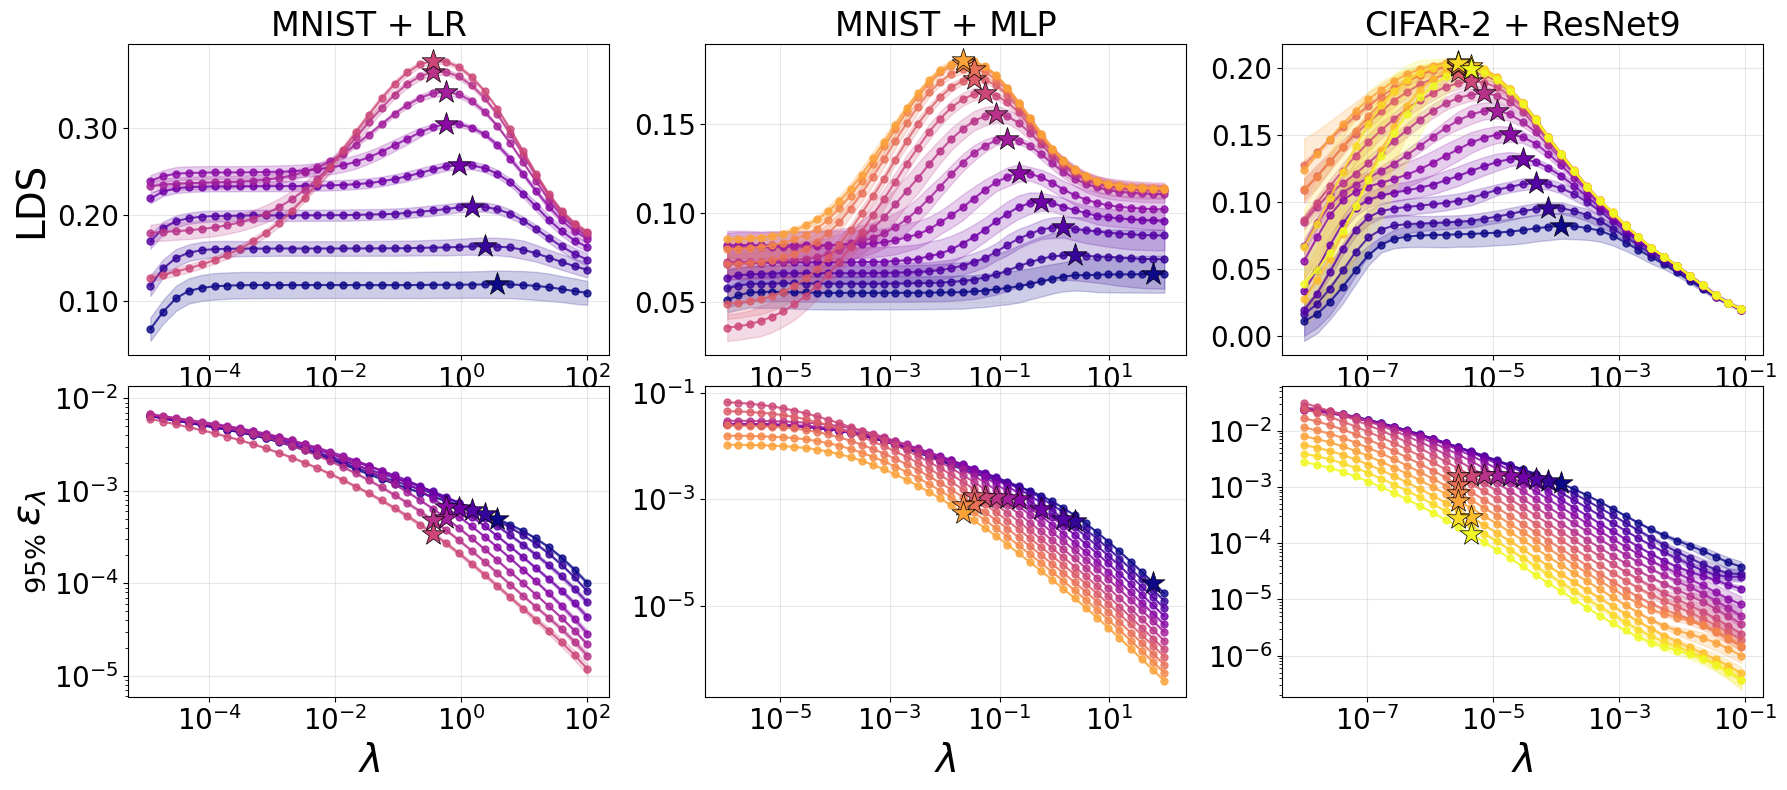


Generating Separate Legend Components
Saved m colorbar to ./figures/faithfulness_utility/m_colorbar.pdf


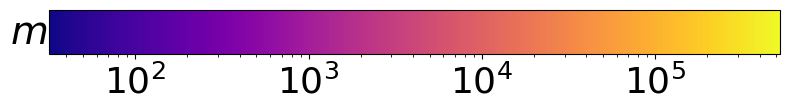

Saved lambda star legend to ./figures/faithfulness_utility/lambda_star_legend.pdf


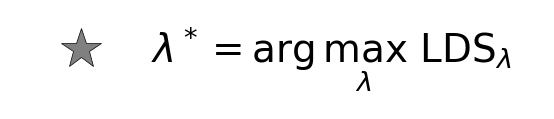


All figures saved to ./figures/faithfulness_utility/
  - Main figure: faithfulness_utility_combined.pdf
  - m colorbar: m_colorbar.pdf (8×1.2 inches)
  - λ* legend: lambda_star_legend.pdf (6×1.2 inches)
You can concatenate the legend components horizontally to create the full legend.


In [75]:
# =============================================================================
# Generate and save combined 2×3 figure as PDF
# =============================================================================

figures_dir = "./figures"
os.makedirs(figures_dir, exist_ok=True)
os.makedirs(f"{figures_dir}/faithfulness_utility", exist_ok=True)

if all_results:
    # Print summary table
    print("Summary Table (λ* selected via argmax test LDS):")
    print("=" * 85)
    print_fu_summary_table(all_results)

    # Combined 2×3 plot: Test LDS (top) and ε_95 (bottom) for each dataset-model
    print("\n" + "=" * 60)
    print("Plotting Combined 2×3 Figure")
    print("(Top row: Test LDS, Bottom row: ε_95)")
    print("=" * 60)
    combined_path = f"{figures_dir}/faithfulness_utility/faithfulness_utility_combined.pdf"

    # By default, uses sensible lambda ranges for each dataset
    # Pass lambda_ranges=None to show all lambda values
    # Or pass custom ranges: lambda_ranges={"mnist_lr": (1e-7, 1e-3), ...}
    plot_faithfulness_utility_combined(all_results, save_path=combined_path, figsize=(18, 8))

    # Create separate legend components that can be concatenated externally
    print("\n" + "=" * 60)
    print("Generating Separate Legend Components")
    print("=" * 60)

    # Create m colorbar (matching spectrum_bounds.ipynb exactly)
    m_colorbar_path = f"{figures_dir}/faithfulness_utility/m_colorbar.pdf"
    create_m_colorbar(all_results, save_path=m_colorbar_path, figsize=(8, 1.2), fontsize=28)

    # Create λ* star legend
    lambda_star_legend_path = f"{figures_dir}/faithfulness_utility/lambda_star_legend.pdf"
    create_lambda_star_legend(save_path=lambda_star_legend_path, figsize=(6, 1.2), fontsize=28)

    print("\n" + "=" * 60)
    print(f"All figures saved to {figures_dir}/faithfulness_utility/")
    print(f"  - Main figure: faithfulness_utility_combined.pdf")
    print(f"  - m colorbar: m_colorbar.pdf (8×1.2 inches)")
    print(f"  - λ* legend: lambda_star_legend.pdf (6×1.2 inches)")
    print("You can concatenate the legend components horizontally to create the full legend.")
    print("=" * 60)
else:
    print("No results loaded. Run the faithfulness_utility.py experiment first:")
    print("  python faithfulness_utility.py --dataset mnist --model lr --num_trials 5")
    print("  python faithfulness_utility.py --dataset mnist --model mlp --num_trials 5")
    print("  python faithfulness_utility.py --dataset cifar2 --model resnet9 --num_trials 5 --proj_type sjlt")